In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal as ss
import pickle
import scipy.linalg as sl

In [4]:
name = "mati"
signal_type = "wyobrazenie"
merged= np.load(f"{name}_{signal_type}_dane.npy")
with open(f"{name}_{signal_type}_EEG.pkl", "rb") as f:
    EEG_mati = pickle.load(f)

Fs = int(EEG_mati["sampling"])
channels_names = EEG_mati['channels_names']
locs_uni = [2, 4,
          6, 7, 8, 9, 10,
          11, 12, 13, 14, 15,
          16, 17, 18, 19,20,
          22,24] # system 10-20; pozycje do wyplotowania na subplotach 5x5

locs_standard = [i for i in range(1,20)]
_, trials_count, channels_count, samples_count = merged.shape

SPECTROGRAM AND VISUALIZATION FUNCTIONS

In [5]:
def spectrogram(signal, hand = None, fs = Fs, nlap = True):


  # hand -> [int] 0- left, 1 - right
  
  NFFT  = int(fs)
  h = ss.windows.hamming(NFFT)

  if nlap:
    noverlap_set = NFFT - 1
  else:
    noverlap_set = NFFT - 10

  if hand != None:
    signal = signal[hand]
    print("Hand is not None")

  f, t, Sxx = ss.spectrogram(signal, fs, nperseg= NFFT, noverlap = noverlap_set, scaling = 'spectrum', window = h, axis = -1)
  Sxx_mean = np.mean(Sxx, axis = 0)

  return Sxx, t, f, Sxx_mean

In [6]:
def EEG_topology(mapa, t, f, title, f_limit=50, l=locs_uni, fs=Fs, ch_names=channels_names, ax_title = channels_names, global_scale=False, vmin = None, vmax = None):
    """
    Wizualizacja mapy czasowo-częstotliwościowej EEG dla wielu kanałów.
    
    Parametry:
    - mapa: lista lub tablica NumPy z danymi EEG (kanały na częstotliwości na czas)
    - t: oś czasu
    - f: oś częstotliwości
    - title: tytuł wykresu
    - f_limit: maksymalna częstotliwość do wyświetlenia (domyślnie 50 Hz)
    - l: układ kanałów EEG (lokalizacje w siatce subplotów)
    - fs: częstotliwość próbkowania
    - ch_names: nazwy kanałów EEG
    - global_scale: jeśli True, używa wspólnej skali kolorów dla wszystkich mapek
    """
    
    NFFT = int(fs)
    plt.figure(figsize=(10, 10))  
    plt.suptitle(title, fontsize=20, fontfamily='serif', fontweight='bold')

    # Ustalanie zakresu kolorów dla globalnej skali
    if global_scale:
        all_data = np.array([mapa[ch][:f_limit, :] for ch in range(len(ch_names))])
        if vmin == None and  vmax == None:
            vmin, vmax = np.min(all_data), np.max(all_data)  # Wspólna skala kolorów

    axes = []
    for ch in range(len(ch_names)):
        ax = plt.subplot(5, 5, l[ch])
        ax.set_title(ax_title[ch], fontsize=10)
        axes.append(ax)

        # Rysowanie mapy EEG z opcjonalną globalną skalą kolorów
        im = ax.imshow(
            mapa[ch][:f_limit, :], 
            aspect='auto', 
            origin='lower',
            extent=(t[0] - (NFFT / 2) / fs - 2, t[-1] - (NFFT / 2) / fs - 2, f[0], f[f_limit]),
            interpolation='nearest',
            cmap='coolwarm',  # Możesz zmienić np. na 'plasma', 'viridis'
            vmin=vmin, vmax=vmax  # Jeśli global_scale=True, ustawia stałą skalę kolorów
        )

        # Linia odniesienia (teraz jasnoszara, żeby była widoczna na każdej mapie)
        ax.axvline(x=0, color='w', linestyle='--', alpha=0.5)

    # Dodanie wspólnej skali kolorów tylko jeśli global_scale=True
    if global_scale:
        cbar_ax = plt.gcf().add_axes([0.92, 0.3, 0.02, 0.4])  # Wspólna oś dla colorbar
        plt.colorbar(im, cax=cbar_ax)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar
    plt.show()


Spacial filters - COMMON PATERNS SEPARATION (CPS)

Czy w końcu mamy dzielić przez ślad? -> nie

We want to split EEG_signal by trials for train & test datasets 
Why? To make sure that tehre is no data leakage through "W" matrix
We'll calculate the W only from traintest and apply to both train and test datasets.

-- calibration simulation ---

In [7]:
L = EEG_mati["lewa"]
P = EEG_mati["prawa"]

In [8]:
# L ma kształt (30, 19, 2048)
num_trials = L.shape[0]
indices = np.random.permutation(num_trials)

# Losowy podział na 20 treningowych i 10 testowych
train_indices = indices[:20]
test_indices = indices[20:]

L_train = L[train_indices, :, :]
L_test = L[test_indices, :, :]


In [9]:
# P ma kształt (30, 19, 2048)
num_trials2 = P.shape[0]
indices2 = np.random.permutation(num_trials2)

# Losowy podział na 20 treningowych i 10 testowych
train_indices2 = indices2[:20]
test_indices2 = indices2[20:]

P_train = P[train_indices2, :, :]
P_test = P[test_indices2, :, :]

In [10]:
from sklearn.covariance import LedoitWolf

In [11]:
T = samples_count/Fs
t = np.arange(0,T, 1/Fs)

baseline_ind = np.where(t<2)[0]
move_ind = np.where(t>2)[0]

R_L = np.zeros((channels_count,channels_count))
R_P = np.zeros((channels_count,channels_count))
trial_count = 20

for trial in range(trial_count):
    estimator = LedoitWolf()

    L = L_train[trial, :, move_ind[0]:]
    estimator.fit(L.T)  
    tmp = estimator.covariance_ 
    R_L = R_L + tmp#/ np.trace(tmp)

    estimator2 = LedoitWolf()
    P = P_train[trial, :, move_ind[0]:]
    estimator2.fit(P.T)  # Uwaga: musisz transponować, bo fit oczekuje kształtu (n_samples, n_features)
    tmp = estimator2.covariance_
    R_P = R_P + tmp#/ np.trace(tmp)

R_L = R_L/ trials_count
R_P = R_P/ trials_count

Lambda, W = sl.eigh(R_L, R_P)



Let's examin the W vector and then have a close-up on smaller values

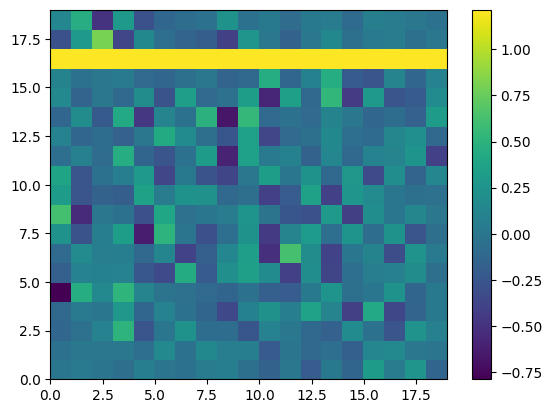

In [12]:
plt.pcolor(W.T)
plt.colorbar()

Then it's time to take a topology-oriented look and see how the chosen vector W (we have 19 vectors) looks on the head topology

In [13]:
def csp_topology(wektor, title, l=locs_uni, ch_names=channels_names, 
                 ax_title=channels_names, global_scale=False, vmin=None, vmax=None):

    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=20, fontfamily='serif', fontweight='bold')

    # Automatyczne ustawienie zakresu kolorów
    if not global_scale:
        vmin, vmax = np.min(wektor), np.max(wektor)

    for ch in range(len(ch_names)):
        ax = plt.subplot(5, 5, l[ch])
        ax.set_title(ax_title[ch], fontsize=10)

        # Tworzenie macierzy 1x1 zawierającej tylko wartość wektora dla danego kanału
        color_matrix = np.array([[wektor[ch]]])

        # Wyświetlanie wartości jako kolor
        im = ax.imshow(color_matrix, cmap='coolwarm', vmin=vmin, vmax=vmax)

        # Wyświetlanie wartości liczbowej na środku
        ax.text(0, 0, f"{wektor[ch]:.2f}", ha='center', va='center', fontsize=12, 
                color='black', fontweight='bold')

        # Usunięcie osi dla czystego wyglądu
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

    # Dodanie wspólnej skali kolorów jeśli global_scale=True
    if global_scale:
        cbar_ax = plt.gcf().add_axes([0.92, 0.3, 0.02, 0.4])  # Oś dla colorbar
        plt.colorbar(im, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  
    plt.show()

W_topology calculation needs to be done only once. The values are now absolute. 

In [14]:
W_topology = np.abs(np.linalg.inv(W))

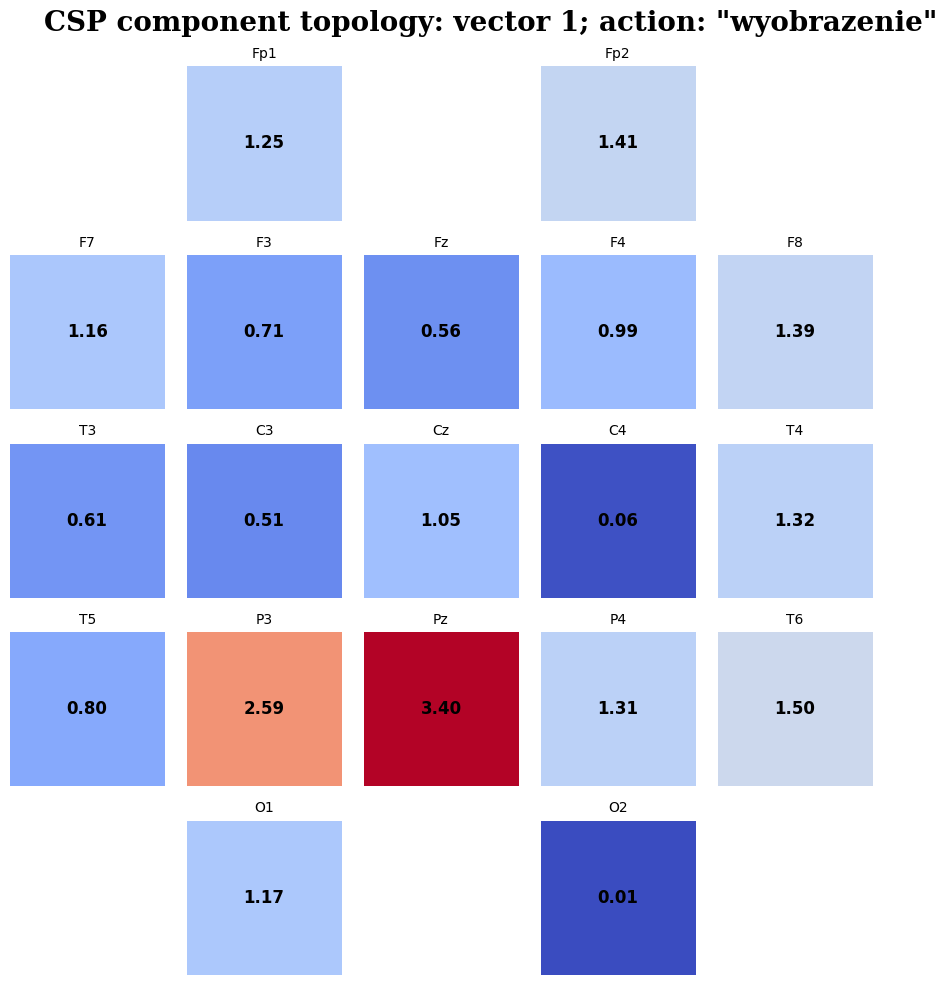

In [15]:
vector = '1'
scale = 'global'

W_01 = W_topology[1]
csp_topology(W_01, title = f'CSP component topology: vector {vector}; action: "{signal_type}"')

This is the topology for the first non-zero component (corresponding to eigenvalue 0.47). We can see it is focused on the frontal.

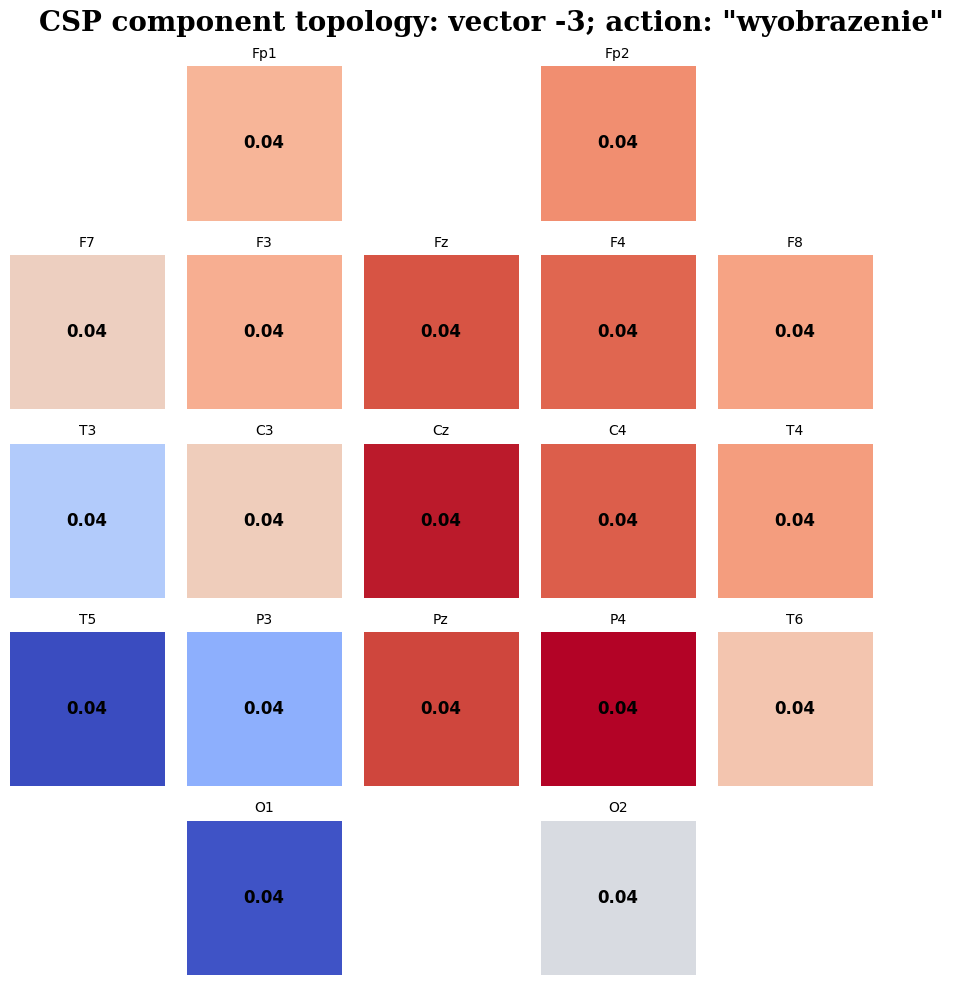

In [16]:
vector = '-3'
scale = 'global'

W_2 = np.abs(W_topology[-3])
csp_topology(W_2, title = f'CSP component topology: vector {vector}; action: "{signal_type}"')

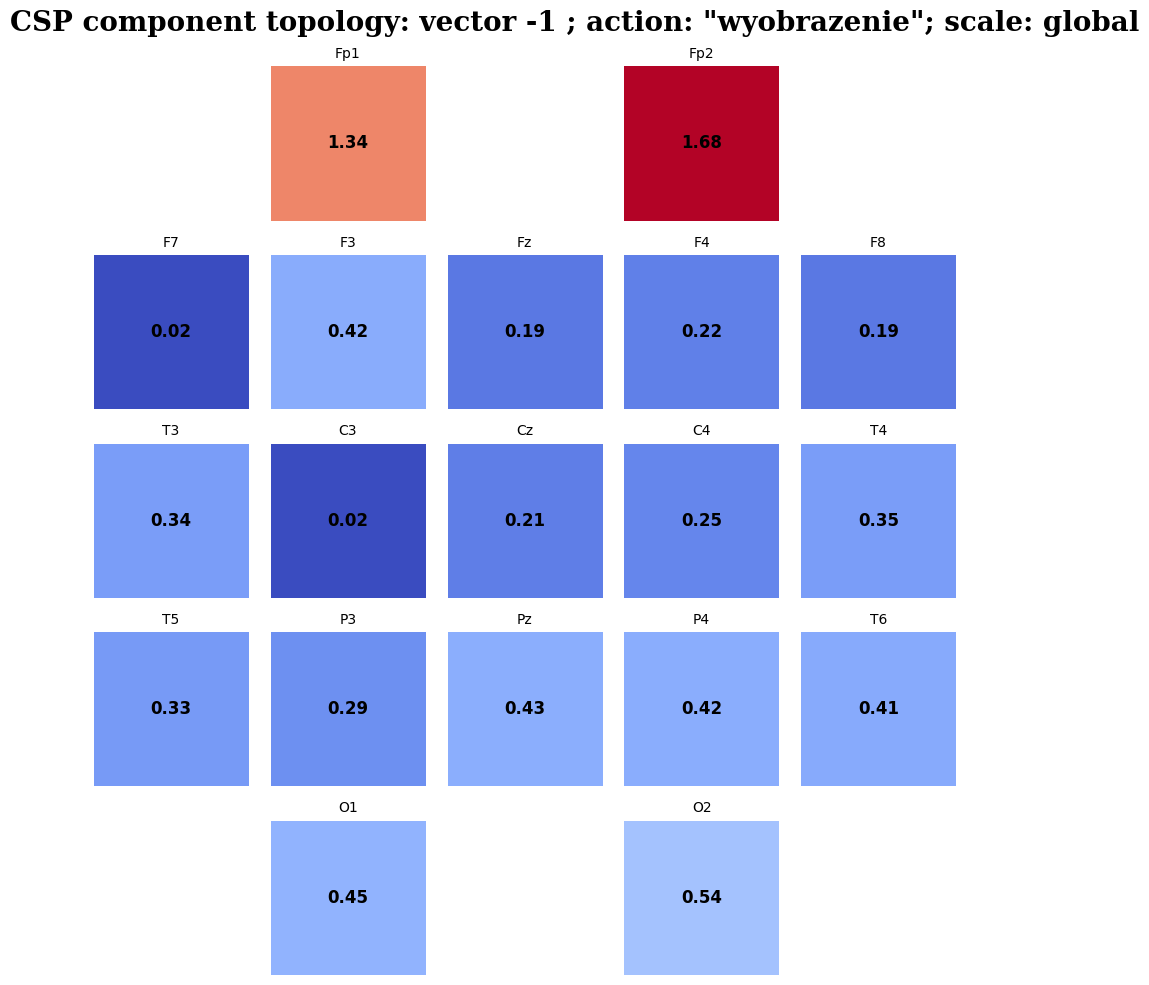

In [17]:
side = '-1'
scale = 'global'

W_1 = np.abs(W_topology[-1])
csp_topology(W_1, title = f'CSP component topology: vector {side} ; action: "{signal_type}"; scale: {str(scale)}')

Let's choose the vector under index of 1

It is wanted to be resolved by eigh function: a @ v = b @ v @ w

In [18]:
Lambda #values examination

array([0.68849943, 0.77097067, 0.87225375, 0.89760984, 0.91042542,
       0.97122008, 0.97698851, 0.99125922, 1.01301332, 1.02374326,
       1.05745553, 1.08840385, 1.09649583, 1.1177113 , 1.13945689,
       1.23725104, 1.29195348, 1.55774829, 1.71854581])

Mind the "fancy indexing"

In [19]:
S_L_train = np.zeros((20, channels_count, len(move_ind)))
S_L_test = np.zeros((10, channels_count, len(move_ind)))

S_P_train = np.zeros((20, channels_count, len(move_ind)))
S_P_test = np.zeros((10, channels_count, len(move_ind)))

In [20]:
for trial in range(20):
    S_L_train[trial, :, :] = W.T @ L_train[trial, :, move_ind[0]:]
    S_P_train[trial, :, :] = W.T @ P_train[trial, :, move_ind[0]:]

for trial in range(10):
    S_L_test[trial, :, :] = W.T @ L_test[trial, :, move_ind[0]:]
    S_P_test[trial, :, :] = W.T @ P_test[trial, :, move_ind[0]:]


I checked and S_L and S_P hold non-zero values (after fixing a typo in the word "trial" in the loop)

- Let's add +2 to t_left_cps, because we don't involve beaseline
- We need to deteriorate the resolusion of time, because 1280 woudl be too much for classification (i change step in noverlap from 1 to 10)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_1650/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


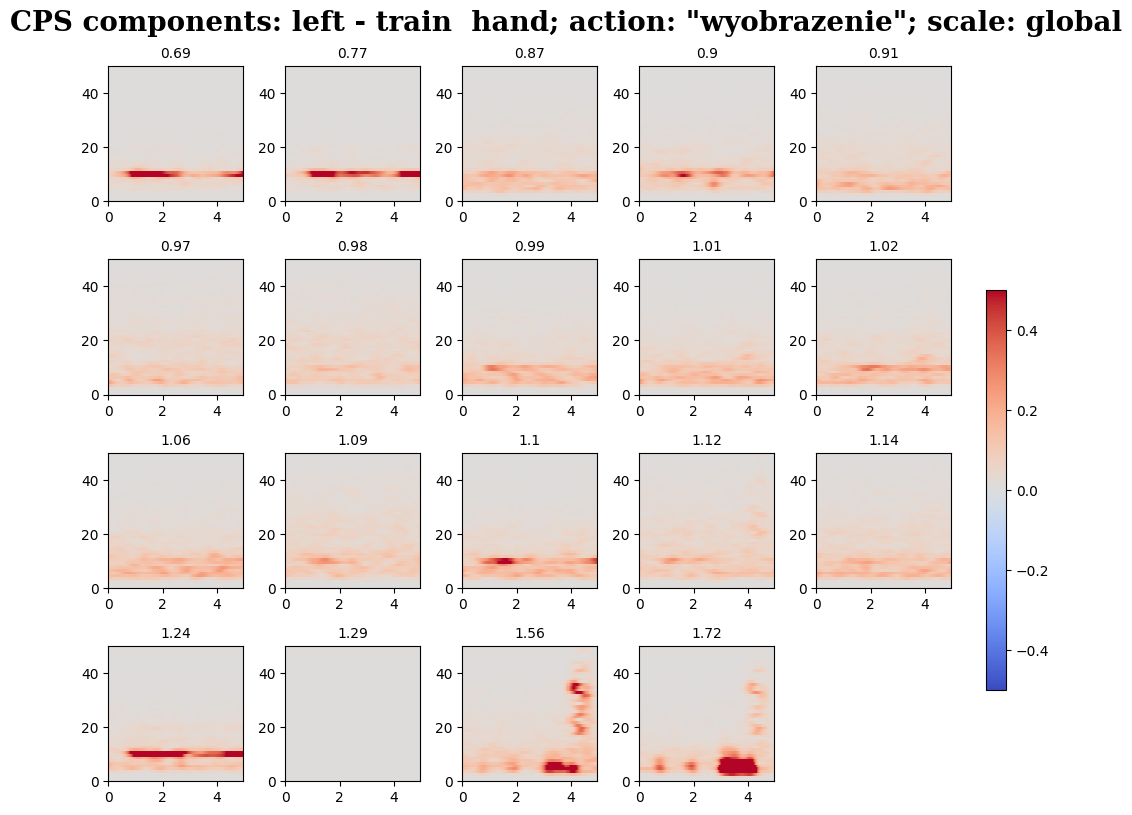

In [21]:
side = 'left - train '
scale = 'global'
freq_limit = 50

rounded_Lambda = list(map(lambda x: round(x, 2), Lambda))

Sxx_left_train_cps, t_left_train_cps, f_left_train_cps, Sxx_mean_left_train_cps = spectrogram(S_L_train, nlap = False)
t_left_train_cps = t_left_train_cps + 2
EEG_topology(Sxx_mean_left_train_cps, t_left_train_cps, f_left_train_cps, title = f'CPS components: {side} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -0.5, vmax = 0.5, ax_title = rounded_Lambda, l = locs_standard)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_1650/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


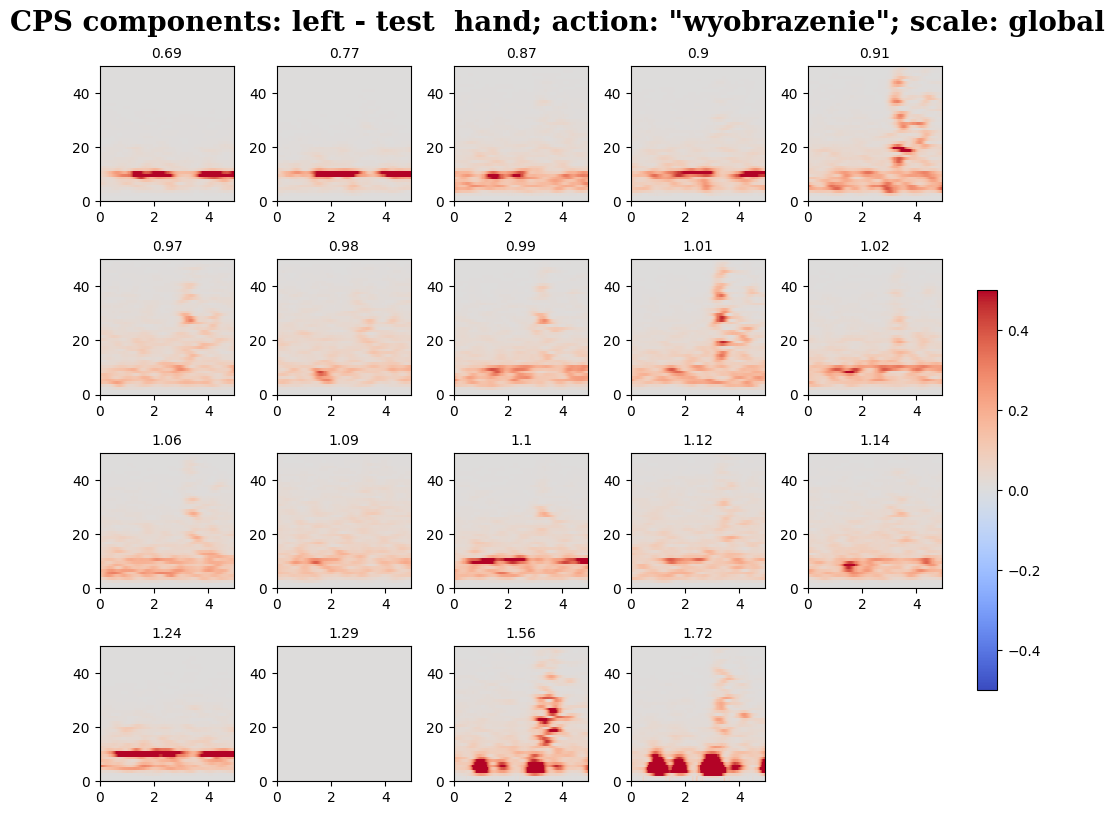

In [22]:
side = 'left - test '
scale = 'global'
freq_limit = 50

rounded_Lambda = list(map(lambda x: round(x, 2), Lambda))

Sxx_left_test_cps, t_left_test_cps, f_left_test_cps, Sxx_mean_left_test_cps = spectrogram(S_L_test, nlap = False)
t_left_test_cps = t_left_test_cps + 2
EEG_topology(Sxx_mean_left_test_cps, t_left_test_cps, f_left_test_cps, title = f'CPS components: {side} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -0.5, vmax = 0.5, ax_title = rounded_Lambda, l = locs_standard)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_1650/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


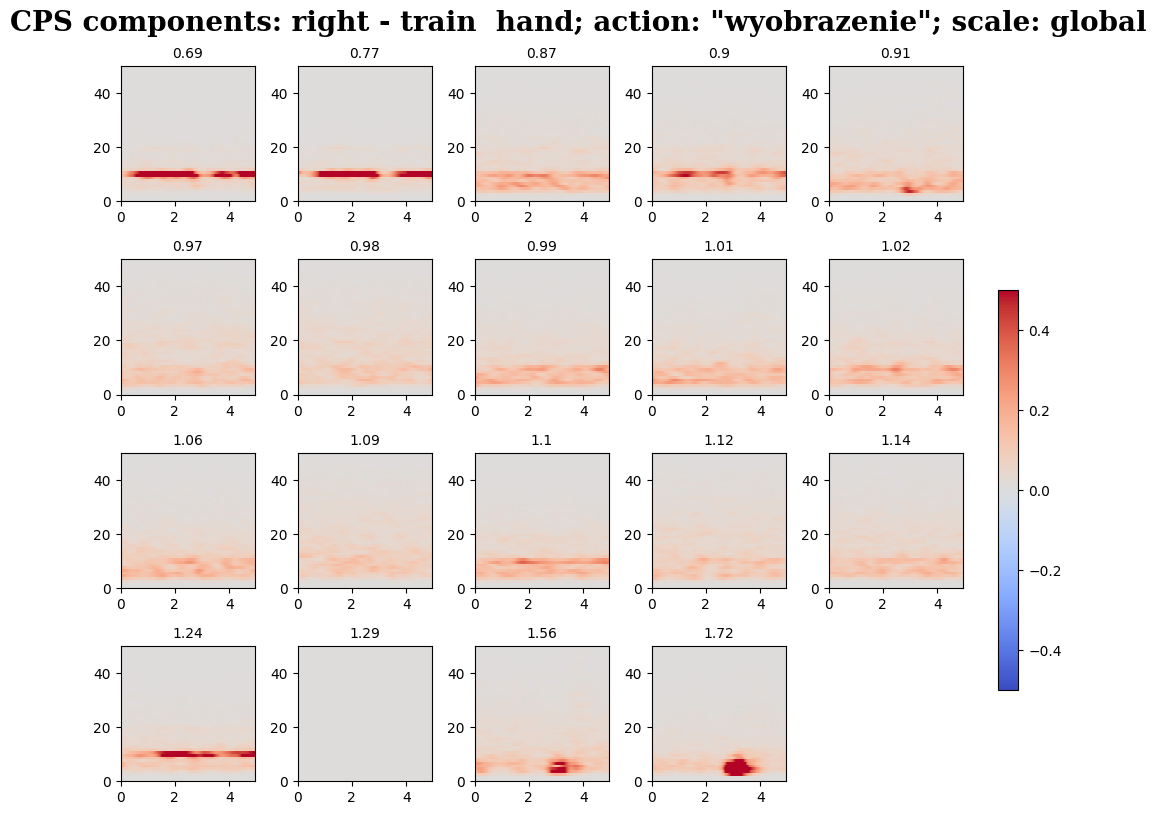

In [23]:
side = 'right - train '
scale = 'global'
freq_limit = 50

rounded_Lambda = list(map(lambda x: round(x, 2), Lambda))

Sxx_right_train_cps, t_right_train_cps, f_right_train_cps, Sxx_mean_right_train_cps = spectrogram(S_P_train, nlap = False)
t_right_train_cps = t_right_train_cps + 2
EEG_topology(Sxx_mean_right_train_cps, t_right_train_cps, f_right_train_cps, title = f'CPS components: {side} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -0.5, vmax = 0.5, ax_title = rounded_Lambda, l = locs_standard)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_1650/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


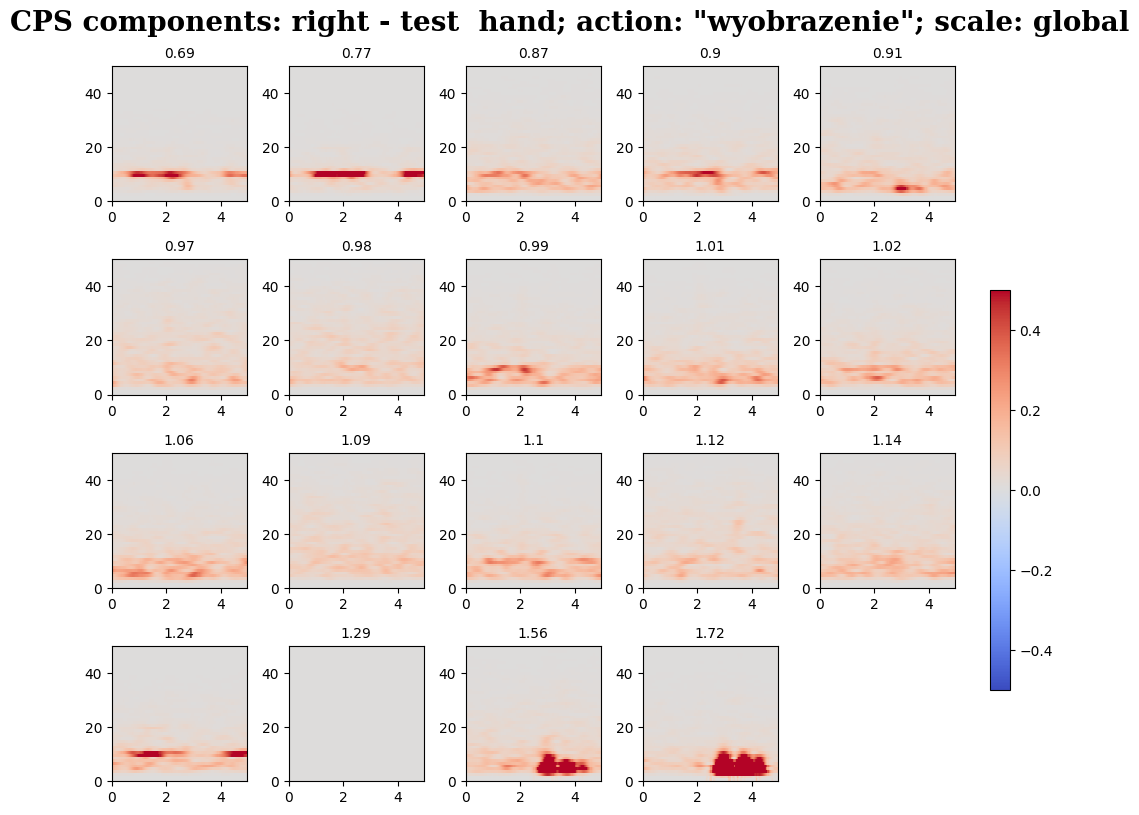

In [24]:
side = 'right - test '
scale = 'global'
freq_limit = 50

rounded_Lambda = list(map(lambda x: round(x, 2), Lambda))

Sxx_right_test_cps, t_right_test_cps, f_right_test_cps, Sxx_mean_right_test_cps = spectrogram(S_P_test, nlap = False)
t_right_test_cps = t_right_test_cps + 2
EEG_topology(Sxx_mean_right_test_cps, t_right_test_cps, f_right_test_cps, title = f'CPS components: {side} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -0.5, vmax = 0.5, ax_title = rounded_Lambda, l = locs_standard)

Let's work on classification problem for the last component - corresponding to the eigenvalues 1.42

In [25]:
Sxx_left_train_cps[:, -3, :30, :].shape

(20, 30, 128)

In [26]:
def data_acquisition_left(Sxx_left_cps, component_ind):
    # Pobranie widma dla lewej strony
    #ucinamy częstotliwości do 30 Hz

    #trail - freqs - time 
    spectrogram_left = Sxx_left_cps[:, component_ind, :30, :]
    trial_count = Sxx_left_cps.shape[0]
    time_points = spectrogram_left.shape[-1]

    sig_left = np.zeros((trial_count, 30 * time_points))

    for trial in range(trial_count):
        sig_left[trial][0:30 * time_points] += spectrogram_left[trial].reshape(-1)

    return pd.DataFrame(sig_left)

def data_acquisition_right(Sxx_right_cps, component_ind):
    # Pobranie widma dla lewej strony
    #ucinamy częstotliwości do 30 Hz

    #trail - freqs - time 
    spectrogram_right = Sxx_right_cps[:, component_ind, :30, :]
    trial_count = 30
    time_points = spectrogram_right.shape[-1]

    sig_right = np.zeros((30,30 * time_points + 1))
    # Dodanie 30 zer na końcu ostatniego wymiaru (Z -> Z+30)
    for trial in range(trial_count):
        sig_right[trial][0:30 * time_points] += spectrogram_right[trial].reshape(-1)
        sig_right[trial][-1] += 1

    return pd.DataFrame(sig_right)

In [27]:
def summary(comp_index):
    df_left_train = data_acquisition_left(Sxx_left_train_cps, comp_index)
    df_left_test = data_acquisition_left(Sxx_left_test_cps, comp_index)
    df_left_train["label"] = 1
    df_left_test["label"] = 1

    df_right_train = data_acquisition_left(Sxx_right_train_cps, comp_index)
    df_right_test = data_acquisition_left(Sxx_left_test_cps, comp_index)
    df_right_train["label"] = 0
    df_right_test["label"] = 0

    df_train = pd.concat([df_right_train, df_left_train], ignore_index=True)
    df_test = pd.concat([df_right_test, df_left_test], ignore_index=True)
    df_all = pd.concat([df_train, df_test], ignore_index=True)

    return df_all

In [39]:
df_all = summary(-1)

In [40]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, f1_score,
    matthews_corrcoef, roc_curve, auc
)
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [41]:
def classify_cv(model, df_all, n_splits=5, random_state=42):

    X = df_all.drop(columns=["label"])
    y = df_all["label"]

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    accuracies = []
    f1_scores = []
    mccs = []
    aucs = []

    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    plt.figure(figsize=(10, 8))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        mcc = matthews_corrcoef(y_val, y_pred)
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)

        accuracies.append(acc)
        f1_scores.append(f1)
        mccs.append(mcc)
        aucs.append(roc_auc)

        # Interpolacja TPR
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f"Fold {fold} (AUC = {roc_auc:.2f})")

    # Średnia krzywa ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color="b", label=f"Mean ROC (AUC = {mean_auc:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (Stratified {n_splits}-Fold CV)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nAverage Accuracy: {np.mean(accuracies):.4f}")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Average MCC: {np.mean(mccs):.4f}")
    print(f"Average AUC: {np.mean(aucs):.4f}")



In [42]:
model_xgboost = XGBClassifier(
                                n_estimators=100,
                                learning_rate=0.1,
                                max_depth=4,
                                eval_metric="logloss",
                                random_state=42
                            )

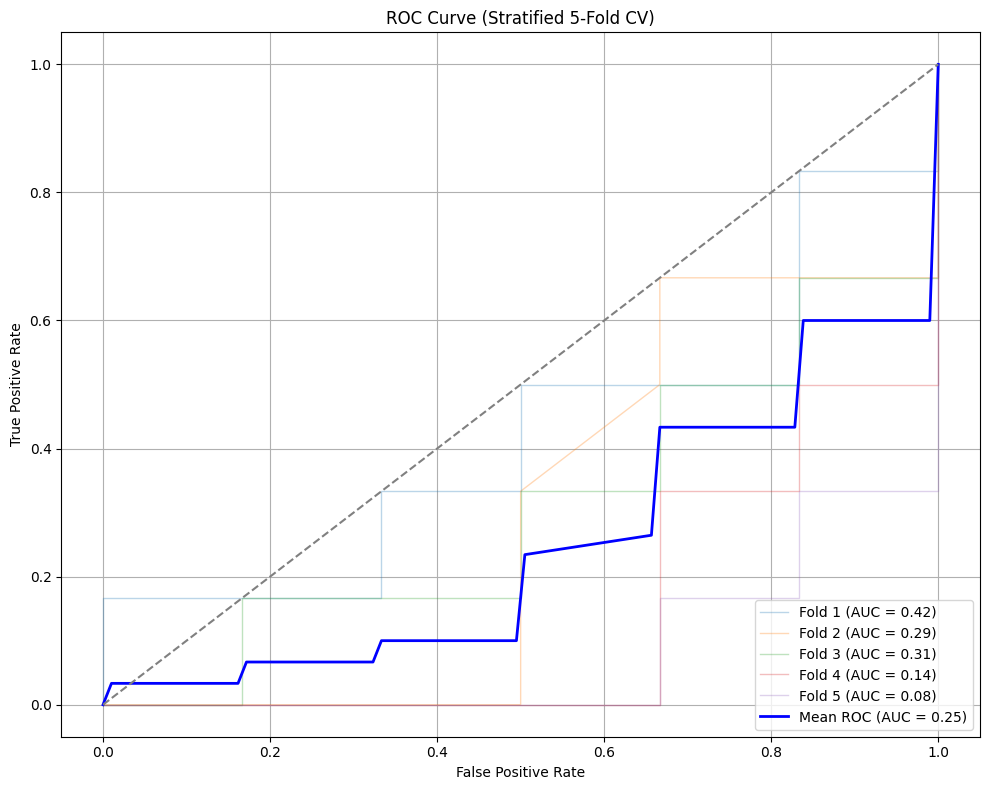


Average Accuracy: 0.3333
Average F1 Score: 0.3266
Average MCC: -0.3433
Average AUC: 0.2472


In [43]:
classify_cv(model_xgboost, df_all)

In [44]:
model_logreg = LogisticRegression(random_state=42, max_iter = 100)

/Users/Maja/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Maja/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

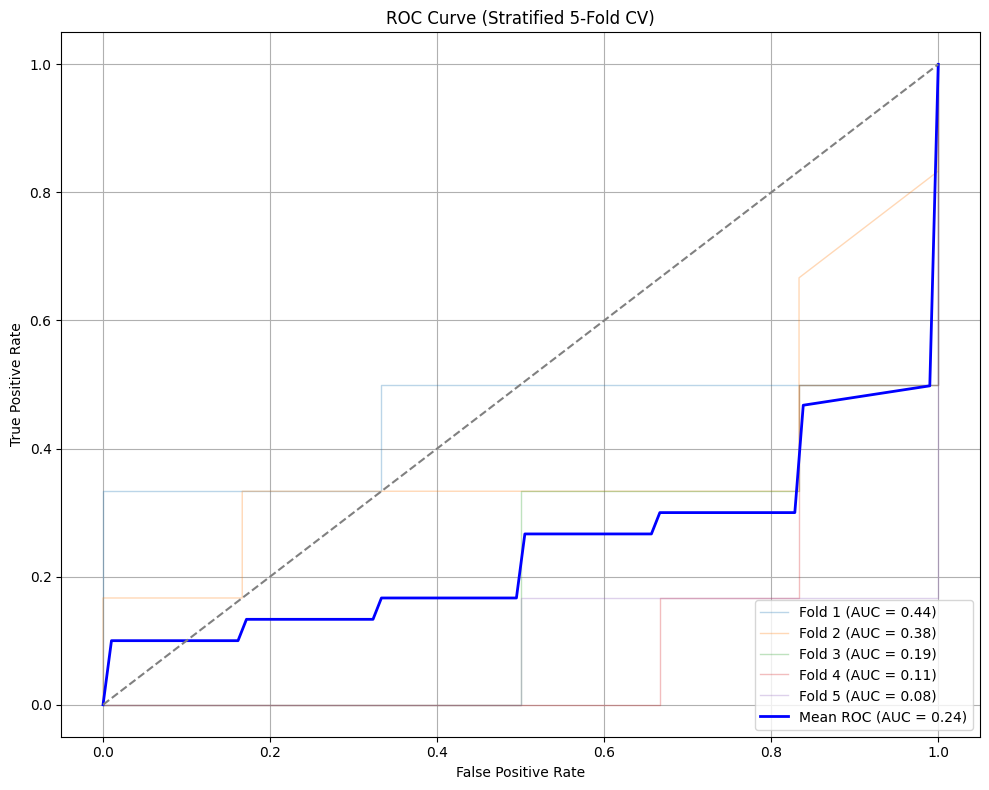


Average Accuracy: 0.3500
Average F1 Score: 0.2980
Average MCC: -0.2967
Average AUC: 0.2417


In [45]:
classify_cv(model_logreg, df_all)

In [46]:
model_RF = RandomForestClassifier(n_estimators=100, random_state=42)

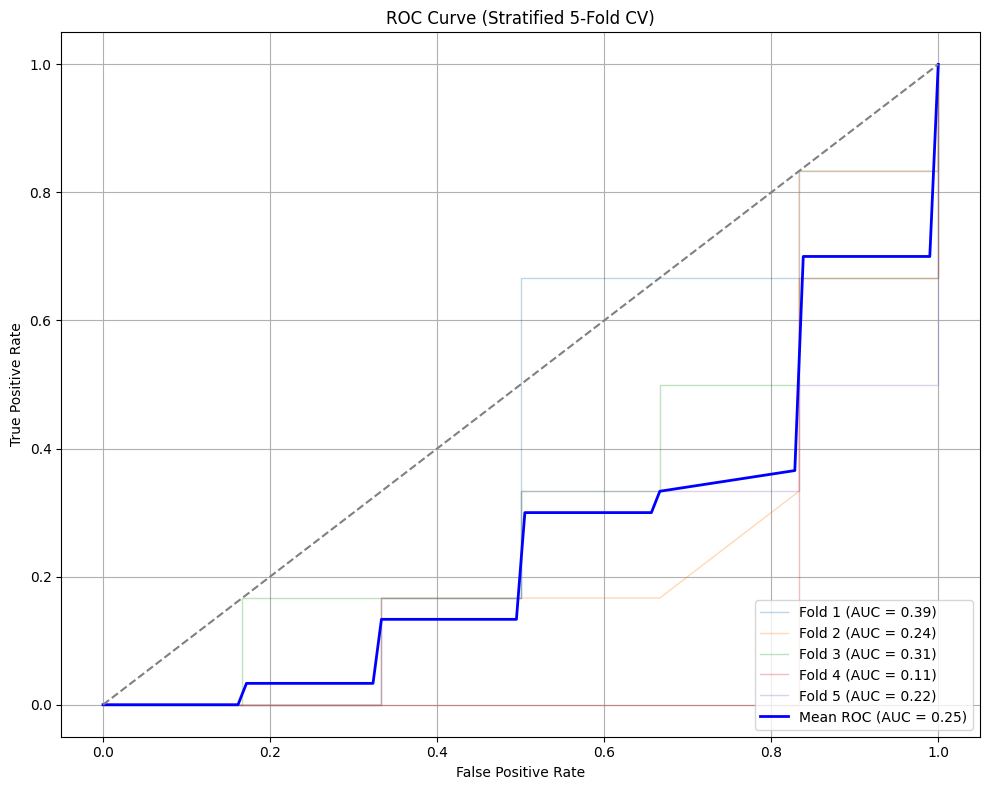


Average Accuracy: 0.3667
Average F1 Score: 0.3770
Average MCC: -0.2757
Average AUC: 0.2528


In [47]:
classify_cv(model_RF, df_all)

In [48]:
model_SVM = SVC(kernel='rbf', random_state=42, probability=True)

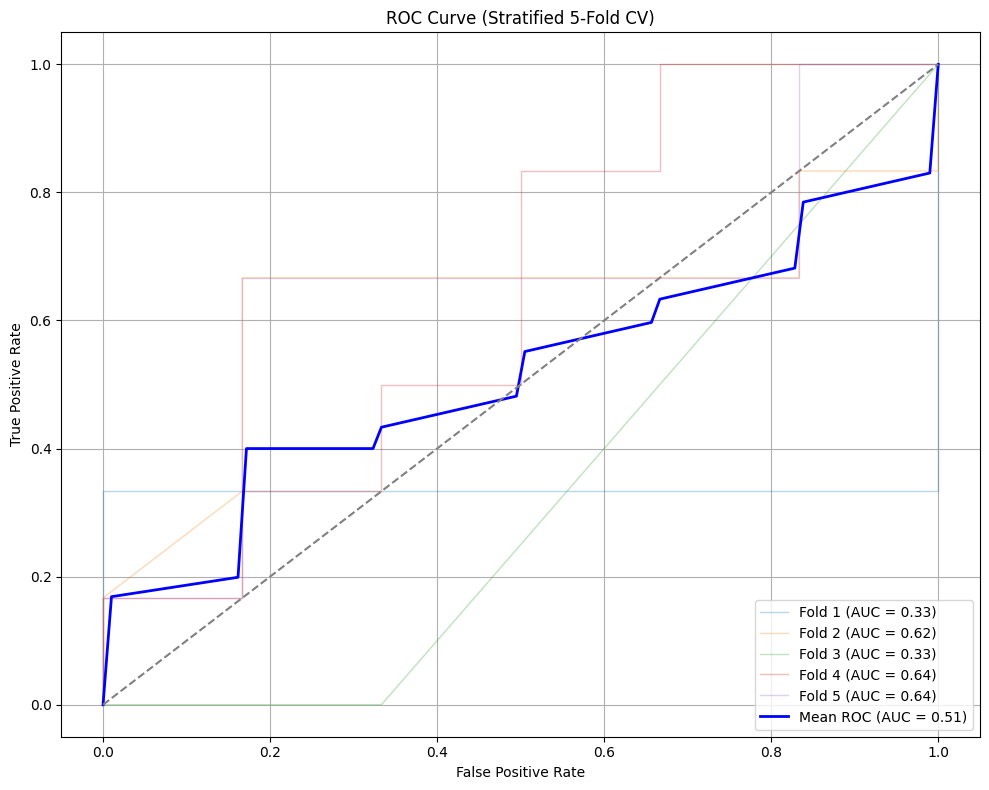


Average Accuracy: 0.4500
Average F1 Score: 0.0500
Average MCC: -0.1497
Average AUC: 0.5139


In [49]:
classify_cv(model_SVM, df_all)